# Population Inference on GWTC-3

The thrid gravitational-wave transient catalog [GWTC-3](https://arxiv.org/abs/1811.12907) includes all compact binary coalescences observed during Advanced LIGO/Virgo's first three oberving runs.

`GWPopulation` builds upon [Bilby](https://git.ligo.org/lscsoft/bilby) ([arXiv:1811.02042](https://arxiv.org/abs/1811.02042)) to provide simple, modular, user-friendly, population inference.

There are many [implemented models](https://colmtalbot.github.io/gwpopulation/_autosummary/gwpopulation.models.html#module-gwpopulation.models) and an example of defining custom models is included below.
In this example we use:

- A mass distribution in primary mass and mass ratio from Talbot & Thrane (2018) ([arXiv:1801:02699](https://arxiv.org/abs/1801.02699)). This is equivalent to the `PowerLaw + Peak` model used in LVK analyses without the low-mass smoothing for computational efficiency.
- Half-Gaussian + isotropic spin tilt distribution from Talbot & Thrane (2017) ([arXiv:1704.08370](https://arxiv.org/abs/1704.08370)).
- Beta spin magnitude distribution from Wysocki+ (2018) ([arXiv:1805:06442](https://arxiv.org/abs/1805.06442)).
- Each of these are also available with independent but identically distributed spins.
- Redshift evolution model as in Fishbach+ (2018) ([arXiv:1805.10270](https://arxiv.org/abs/1805.10270)).

_Setup_

If you're using colab.research.google.com you will want to choose a GPU-accelerated runtime (I'm going to use a T4 GPU).

"runtime"->"change runtime type"->"Hardware accelerator = GPU"


_Note_

This is largely reproduced from the demonstration for [wcosmo](https://wcosmo.readthedocs.io/en/latest/examples/gwtc3.html) except with the cosmology fixed.

## Install some needed packages

All of the dependencies for this are integrated into `GWPopulation`.
These include `Bilby` and `dynesty` for sampling.

In [1]:
!pip install gwpopulation --quiet --progress-bar off

## Download data

We need to download the data for the events and simmulated "injections" used to characterize the detection sensitivity.

### Event posteriors

We're using the posteriors from the GWTC-3 data release in a pre-processed format.

The file was produced by [gwpopulation-pipe](https://docs.ligo.org/ratesAndPopulations/gwpopulation_pipe) to reduce the many GB of posterior sample files to a single ~30Mb file.

The choice of events in this file was not very careful and should only be considered qualitatively correct.

The data file can be found [here](https://drive.google.com/drive/folders/1wyfR6sYvYVdBefF9_vrVTp0Btu03OlzL?usp=drive_link).
The original data can be found at [zenodo:5546663](https://zenodo.org/records/5546663) and [zenodo:6513631](https://zenodo.org/records/6513631) along with citation information.

### Sensitivity injections

Again I have pre-processed the full injection set using `gwpopulation-pipe` to reduce the filesize.
The original data is available at [zenodo:7890398](https://zenodo.org/records/7890398) along with citation information.

In [2]:
!gdown https://drive.google.com/uc?id=16gStLIjt65gWBkw-gNOVUqNbZ89q8CLF
!gdown https://drive.google.com/uc?id=10pevUCM3V2-D-bROFEMAcTJsX_9RzeM6

Downloading...
From: https://drive.google.com/uc?id=16gStLIjt65gWBkw-gNOVUqNbZ89q8CLF
To: /Users/colmtalbot/modules/gwpopulation/examples/gwtc-3-injections.pkl
100%|██████████████████████████████████████| 2.69M/2.69M [00:00<00:00, 75.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=10pevUCM3V2-D-bROFEMAcTJsX_9RzeM6
To: /Users/colmtalbot/modules/gwpopulation/examples/gwtc-3-samples.pkl
100%|██████████████████████████████████████| 36.4M/36.4M [00:00<00:00, 60.6MB/s]


## Imports

Import the packages required for the script.
We also set the backend for array operations to `jax` which allows us to take advantage of just-in-time (jit) compilation in addition to GPU-parallelisation when available.

In [3]:
import bilby as bb
import gwpopulation as gwpop
import jax
import matplotlib.pyplot as plt
import pandas as pd
from bilby.core.prior import PriorDict, Uniform
from gwpopulation.experimental.jax import JittedLikelihood, NonCachingModel

gwpop.set_backend("jax")

xp = gwpop.utils.xp

%matplotlib inline

## Load posteriors

We remove two events from the file that shouldn't be there that have NS-like secondaries as we are just interested in BBHs for this demonstration.

In [4]:
posteriors = pd.read_pickle("gwtc-3-samples.pkl")
del posteriors[15]
del posteriors[38]

## Load injections

Load the injections used to characterize the sensitivity of the gravitaitonal-wave survey.

In [5]:
import dill

with open("gwtc-3-injections.pkl", "rb") as ff:
    injections = dill.load(ff)

## Define some models and the likelihood

We need to define `Bilby` `Model` objects for the numerator and denominator independently as these cache some computations interally.

We create a model that uses a cosmology fixed to the Planck 2015 values for flat Lambda CDM.

The `HyperparameterLikelihood` marginalises over the local merger rate, with a uniform-in-log prior.
The posterior for the merger rate can be recovered in post-processing.

We provide:

- `posteriors`: a list of `pandas` DataFrames.
- `hyper_prior`: our population model, as defined above.
- `selection_function`: anything which evaluates the selection function.

We can also provide:

- `conversion_function`: this converts between the parameters we sample in and those needed by the model, e.g., for sampling in the mean and variance of the beta distribution.
- `max_samples`: the maximum number of samples to use from each posterior, this defaults to the length of the shortest posterior.

In [6]:
model = NonCachingModel(
    model_functions=[
        gwpop.models.mass.two_component_primary_mass_ratio,
        gwpop.models.spin.iid_spin,
        gwpop.models.redshift.PowerLawRedshift(cosmo_model="Planck15"),
    ],
)

vt = gwpop.vt.ResamplingVT(model=model, data=injections, n_events=len(posteriors))

likelihood = gwpop.hyperpe.HyperparameterLikelihood(
    posteriors=posteriors,
    hyper_prior=model,
    selection_function=vt,
)

## Define our prior

The mass model has eight parameters that we vary that are described in arXiv:1801:02699. This model is sometimes referred to as "PowerLaw+Peak"

The spin magnitude model is a `Beta` distribution with the usual parameterization, and the spin orientation model is a mixure of a uniform component and a truncated Gaussian that peaks at aligned spin. This combination is sometimes referred to as "Default".

For redshift we use a model that looks like

$$p(z) \propto \frac{d V_{c}}{dz} (1 + z)^{λ - 1}$$

In [7]:
priors = PriorDict()

# mass
priors["alpha"] = Uniform(minimum=-2, maximum=4, latex_label="$\\alpha$")
priors["beta"] = Uniform(minimum=-4, maximum=12, latex_label="$\\beta$")
priors["mmin"] = Uniform(minimum=2, maximum=2.5, latex_label="$m_{\\min}$")
priors["mmax"] = Uniform(minimum=80, maximum=100, latex_label="$m_{\\max}$")
priors["lam"] = Uniform(minimum=0, maximum=1, latex_label="$\\lambda_{m}$")
priors["mpp"] = Uniform(minimum=10, maximum=50, latex_label="$\\mu_{m}$")
priors["sigpp"] = Uniform(minimum=1, maximum=10, latex_label="$\\sigma_{m}$")
priors["gaussian_mass_maximum"] = 100
# spin
priors["amax"] = 1
priors["alpha_chi"] = Uniform(minimum=1, maximum=6, latex_label="$\\alpha_{\\chi}$")
priors["beta_chi"] = Uniform(minimum=1, maximum=6, latex_label="$\\beta_{\\chi}$")
priors["xi_spin"] = Uniform(minimum=0, maximum=1, latex_label="$\\xi$")
priors["sigma_spin"] = Uniform(minimum=0.3, maximum=4, latex_label="$\\sigma$")

priors["lamb"] = Uniform(minimum=-1, maximum=10, latex_label="$\\lambda_{z}$")

## Just-in-time compile

We JIT compile the likelihood object before starting the sampler.
This is done using the `gwpopulation.experimental.jax.JittedLikelihood` class.

We then time the original likelihood object and the JIT-ed version.
Note that we do two evaluations for each object as the first evaluation must compile the likelihood and so takes longer. (In addition to the JIT compilation, `JAX` compiles GPU functionality at the first evaluation, but this is less extreme than the full JIT compilation.)

In [8]:
parameters = priors.sample()
likelihood.parameters.update(parameters)
likelihood.log_likelihood_ratio()
%time print(likelihood.log_likelihood_ratio())
jit_likelihood = JittedLikelihood(likelihood)
jit_likelihood.parameters.update(parameters)
%time print(jit_likelihood.log_likelihood_ratio())
%time print(jit_likelihood.log_likelihood_ratio())

-273.6719945829451
CPU times: user 111 ms, sys: 36.2 ms, total: 147 ms
Wall time: 64 ms
-273.671994582945
CPU times: user 1.3 s, sys: 257 ms, total: 1.56 s
Wall time: 1.1 s
-273.671994582945
CPU times: user 50.4 ms, sys: 3.6 ms, total: 54 ms
Wall time: 15.7 ms


## Run the sampler

We'll use the sampler `dynesty` and use a small number of live points to reduce the runtime (total runtime should be approximately 5 minutes on T4 GPUs via Google colab).
The settings here may not give publication quality results, a convergence test should be performed before making strong quantitative statements.

`bilby` times a single likelihood evaluation before beginning the run, however, this isn't well defined with JAX.

**Note:** sometimes this finds a high likelihood mode, likely due to [breakdowns in the approximation](https://arxiv.org/abs/2304.06138) used to estimate the likelihood. If you see `dlogz > -190`, you should interrupt the execution and restart.

In [9]:
result = bb.run_sampler(
    likelihood=jit_likelihood,
    priors=priors,
    sampler="dynesty",
    nlive=100,
    label="cosmo",
    sample="acceptance-walk",
    naccept=5,
    save="hdf5",
)

15:30 bilby INFO    : Running for label 'cosmo', output will be saved to 'outdir'
15:30 bilby INFO    : Analysis priors:
15:30 bilby INFO    : alpha=Uniform(minimum=-2, maximum=4, name=None, latex_label='$\\alpha$', unit=None, boundary=None)
15:30 bilby INFO    : beta=Uniform(minimum=-4, maximum=12, name=None, latex_label='$\\beta$', unit=None, boundary=None)
15:30 bilby INFO    : mmin=Uniform(minimum=2, maximum=2.5, name=None, latex_label='$m_{\\min}$', unit=None, boundary=None)
15:30 bilby INFO    : mmax=Uniform(minimum=80, maximum=100, name=None, latex_label='$m_{\\max}$', unit=None, boundary=None)
15:30 bilby INFO    : lam=Uniform(minimum=0, maximum=1, name=None, latex_label='$\\lambda_{m}$', unit=None, boundary=None)
15:30 bilby INFO    : mpp=Uniform(minimum=10, maximum=50, name=None, latex_label='$\\mu_{m}$', unit=None, boundary=None)
15:30 bilby INFO    : sigpp=Uniform(minimum=1, maximum=10, name=None, latex_label='$\\sigma_{m}$', unit=None, boundary=None)
15:30 bilby INFO    : 

1it [00:00, ?it/s]

15:37 bilby INFO    : Written checkpoint file outdir/cosmo_resume.pickle
15:37 bilby INFO    : Rejection sampling nested samples to obtain 677 posterior samples
15:37 bilby INFO    : Sampling time: 0:07:00.040342
15:37 bilby INFO    : Summary of results:
nsamples: 677
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.398
ln_bayes_factor: -199.070 +/-  0.398



## Plot some posteriors

We can look at the posteriors on some of the parameters, here the cosmology parameters and the location of the mass peak and the redshift evolution.

We see that the value of the Hubble constant is strongly correlated with the location of the peak in the mass distribution as has been noted elsewhere.

We also include the values of the cosmology parameters reported in the `Planck15` cosmology for reference.

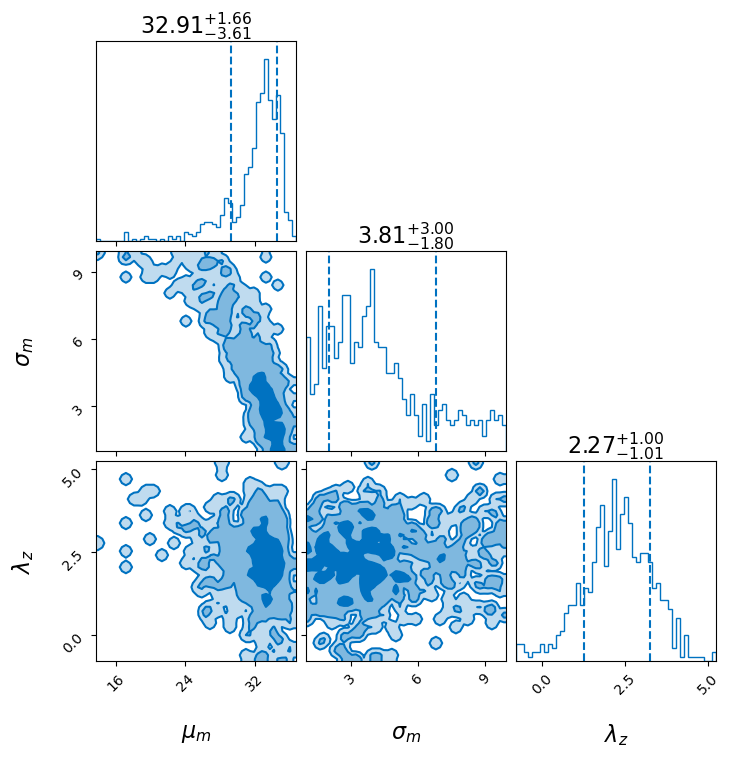

In [10]:
_ = result.plot_corner(save=False, parameters=["mpp", "sigpp", "lamb"])

## Post-processing checks

As mentioned above, hierarchical analyses performed in this way are susceptible to systematic bias due to Monte Carlo error.
To ensure we are not suffering from this issue, we compute the variance in each of our Monte Carlo integrals along with the total variance for each posterior sample.
We then look at whether there are correlations between the log-likelihood, the variance, and the hyperparameters.
If we see significant correlation between the variance and other quantities, it is a sign that our results may not be reliable.

In [11]:
func = jax.jit(likelihood.generate_extra_statistics)

full_posterior = pd.DataFrame(
    [func(parameters) for parameters in result.posterior.to_dict(orient="records")]
).astype(float)
full_posterior.describe()

,alpha,alpha_chi,amax,beta,beta_chi,gaussian_mass_maximum,lam,lamb,ln_bf_0,ln_bf_1,...,var_66,var_67,var_68,var_69,var_7,var_70,var_8,var_9,variance,xi_spin
count,677.000000,677.000000,677.0,677.000000,677.000000,677.0,677.000000,677.000000,677.000000,677.000000,...,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000
mean,2.776850,1.712533,1.0,2.059456,4.765464,100.0,0.036284,2.259357,-10.416216,-10.662652,...,0.001103,0.000925,0.001178,0.000479,0.000318,0.000802,0.000804,0.000955,1.552220,0.645813
std,0.229683,0.441259,0.0,1.067155,0.873841,0.0,0.027913,1.022998,1.306954,1.029802,...,0.000654,0.000457,0.000757,0.000260,0.000151,0.000327,0.000378,0.000413,0.819144,0.240400
min,2.050729,1.001482,1.0,-0.659842,1.862621,100.0,0.004847,-0.784904,-14.955488,-14.237053,...,0.000221,0.000202,0.000293,0.000154,0.000088,0.000136,0.000215,0.000267,0.336554,0.001326
25%,2.621572,1.369770,1.0,1.397719,4.156605,100.0,0.019076,1.660442,-11.316283,-11.319475,...,0.000682,0.000642,0.000735,0.000339,0.000228,0.000601,0.000570,0.000683,1.036452,0.470641
50%,2.784653,1.648453,1.0,1.915804,4.899788,100.0,0.028897,2.268566,-10.398208,-10.665089,...,0.000914,0.000830,0.001011,0.000424,0.000282,0.000750,0.000721,0.000870,1.342318,0.691562
75%,2.937532,2.008287,1.0,2.565101,5.496479,100.0,0.046055,2.986201,-9.532608,-10.007681,...,0.001382,0.001077,0.001412,0.000544,0.000370,0.000951,0.000934,0.001141,1.818107,0.850433
max,3.425676,3.318228,1.0,9.709659,5.994280,100.0,0.384039,5.247202,-6.867461,-7.933087,...,0.005489,0.005247,0.009805,0.004341,0.001919,0.004697,0.004150,0.004305,6.894325,0.996642


In [12]:
full_posterior[result.search_parameter_keys + ["log_likelihood", "variance"]].corr()

,alpha,beta,mmin,mmax,lam,mpp,sigpp,alpha_chi,beta_chi,xi_spin,sigma_spin,lamb,log_likelihood,variance
alpha,1.000000,0.018332,0.049273,0.165293,-0.458561,-0.096644,0.099342,-0.039909,0.032705,-0.067643,0.012180,0.616722,0.213035,0.082727
beta,0.018332,1.000000,-0.030397,-0.108583,-0.049465,-0.047072,-0.011391,0.029325,-0.030322,0.028157,-0.041763,-0.138196,-0.157355,0.144190
mmin,0.049273,-0.030397,1.000000,0.067611,0.026643,0.028545,0.012661,0.004106,-0.055865,0.003692,0.097444,-0.006103,0.035900,-0.037539
mmax,0.165293,-0.108583,0.067611,1.000000,0.025335,-0.076469,0.090215,0.028796,0.035281,0.023455,0.128840,0.069579,-0.168815,-0.039724
lam,-0.458561,-0.049465,0.026643,0.025335,1.000000,-0.552935,0.450844,0.064456,0.012491,-0.030650,0.035253,-0.224907,-0.498883,-0.082098
mpp,-0.096644,-0.047072,0.028545,-0.076469,-0.552935,1.000000,-0.811752,-0.147834,-0.025253,0.099803,-0.151705,-0.222503,0.509110,0.343512
sigpp,0.099342,-0.011391,0.012661,0.090215,0.450844,-0.811752,1.000000,0.044627,-0.046373,-0.076903,0.129302,0.093172,-0.535496,-0.463671
alpha_chi,-0.039909,0.029325,0.004106,0.028796,0.064456,-0.147834,0.044627,1.000000,0.616715,-0.014138,0.295180,0.032030,-0.172487,-0.193389
beta_chi,0.032705,-0.030322,-0.055865,0.035281,0.012491,-0.025253,-0.046373,0.616715,1.000000,0.053659,-0.020179,0.085114,0.138990,0.312379
xi_spin,-0.067643,0.028157,0.003692,0.023455,-0.030650,0.099803,-0.076903,-0.014138,0.053659,1.000000,0.047134,-0.020606,0.200745,0.104602


The most strongly correlated variables are the ones that control the position and width of the peak in the mass distribution.
Below we show a scatter matrix for these variables.
The variance for this analysis has a tail up to ~4 and so may be non-trivially biased.
The simplest method to resolve this is by using more samples for all of the Monte Carlo integrals.

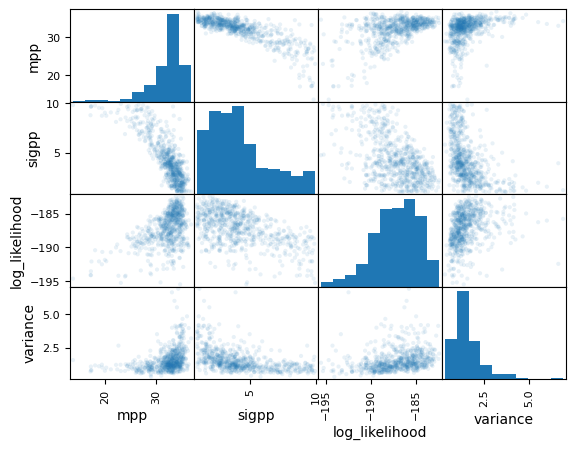

In [13]:
pd.plotting.scatter_matrix(
    full_posterior[["mpp", "sigpp", "log_likelihood", "variance"]],
    alpha=0.1,
)
plt.show()
plt.close()